<a href="https://colab.research.google.com/github/Pehlevan-Group/NTK_Learning_Curves/blob/master/Mode_Err_Expt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reproducing Mode Error Expts

Note that GPU runtime is faster



In [1]:
!pip install -q git+https://github.com/Pehlevan-Group/NTK_Learning_Curves.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Pehlevan-Group/NTK_Learning_Curves.git to /tmp/pip-req-build-rg2h3j2o
  Running command git clone --filter=blob:none --quiet https://github.com/Pehlevan-Group/NTK_Learning_Curves.git /tmp/pip-req-build-rg2h3j2o
  Resolved https://github.com/Pehlevan-Group/NTK_Learning_Curves.git to commit 33b09db385243fec5cf781b04bbadd6bec8934c5
  Preparing metadata (setup.py) ... done
  Created wheel for NTK-Learning-Curves: filename=NTK_Learning_Curves-0.0.0-py3-none-any.whl size=21507 sha256=b7c6196fc854fb971ff91120a8fe7a8abc4189a9969a216d412ff4e12e6adac8
  Stored in directory: /tmp/pip-ephem-wheel-cache-awp_f4mj/wheels/4a/0b/24/82793c406a84a0204ee1e53022bba9d595debbee633a0bb23d
Successfully built NTK-Learning-Curves


In [2]:
from ntk_generalization.utils.gegenbauer import gegenbauer_loop, get_gegenbauer_lax
import scipy.special as spe
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ntk_generalization.utils.compute_NTK_spectrum import get_effective_spectrum
from ntk_generalization.utils.theory_lc import learning_curves_modes
from ntk_generalization.utils import gegenbauer
from ntk_generalization.kernel_regression_lc import mode_err_expt


### Visualize Gegenbauer Polynomials

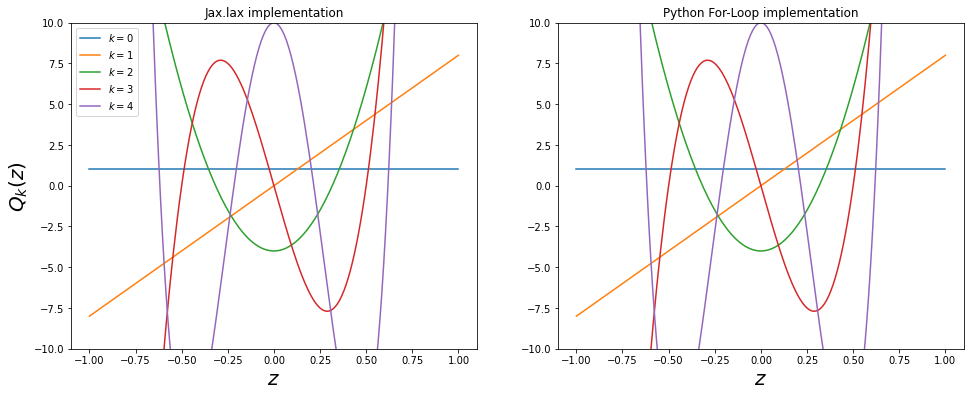

In [3]:
d= 10
alpha = d/2.0 - 1.0
num_pts = 250

z, w = spe.roots_gegenbauer(num_pts, alpha)
Q_lax = get_gegenbauer_lax(z, jnp.arange(5), d)
Q_loop = gegenbauer_loop(z, jnp.arange(5), d)

plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.title('Jax.lax implementation')
for k in range(5):
  plt.plot(z, Q_lax[k,:], label = r'$k = %d$' % k)

plt.xlabel(r'$z$',fontsize = 20)
plt.ylabel(r'$Q_k(z)$',fontsize = 20)
plt.ylim([-10,10])
plt.legend()
plt.subplot(1,2,2)
plt.title('Python For-Loop implementation')
for k in range(5):
  plt.plot(z, Q_loop[k,:])
plt.ylim([-10,10])
plt.xlabel(r'$z$',fontsize = 20)
plt.show()

### Get NTK Spectrum

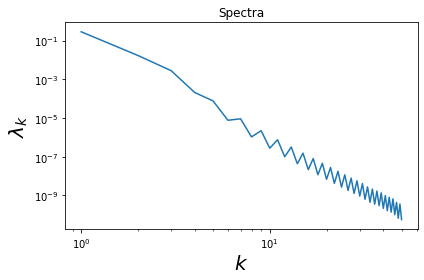

In [4]:
depth = 3
d = 5
kmax = 50
spectrum_full, Ak_sqr = get_effective_spectrum([depth], kmax, d, ker = 'NTK')
spectrum = spectrum_full[0,:]

plt.loglog(jnp.linspace(1,kmax,kmax), spectrum)
plt.xlabel(r'$k$',fontsize =20)
plt.ylabel(r'$\lambda_k$',fontsize=20)
plt.title('Spectra')
plt.tight_layout()
plt.show()

### Kernel Regression Experiment

In [5]:
P_vals = np.logspace(0.0, 3.0,10).astype('int')
num_repeats = 25
lamb = 1e-4
k_expts = [1,2,3,4]
all_mode_errs = np.zeros((len(k_expts), len(P_vals)))
for i,k in enumerate(k_expts):
  print("k = %d" % k)
  for j, P in enumerate(P_vals):
    all_mode_errs[i,j] = mode_err_expt(P, k, spectrum, kmax, d, num_repeats, lamb = lamb).mean()

k = 1
k = 2
k = 3
k = 4


### Compute Theoretical Mode Errors

In [6]:
p = jnp.logspace(-0.25, 3.0, 100)
degens = jnp.array( [ gegenbauer.get_degeneracy(d,k) for k in range(kmax)] )
# note that spectrum for (orthonormal ) harmonics is coefficient spectum[k] * A[k]
# where Qk(x*x') = Ak \sum_{m} Y_{km}(x) Y_{km}(x'), (computed above)
sol = learning_curves_modes(p, spectrum*jnp.sqrt(Ak_sqr) , degens, lamb = lamb)

### Plot Final Result

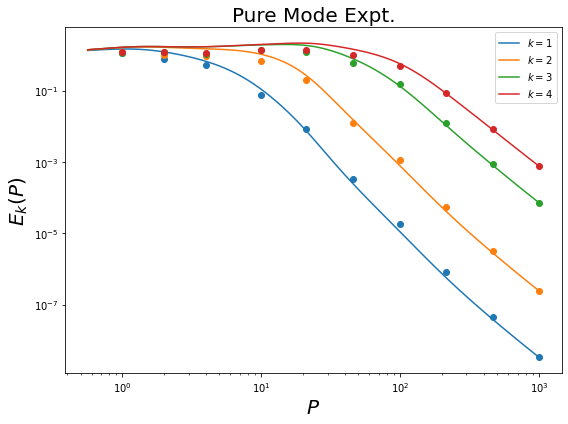

In [9]:
plt.figure(figsize = (8,6))
for i,k in enumerate(k_expts):
  plt.loglog(P_vals, all_mode_errs[i,:]/all_mode_errs[i,-1] * sol[k,-1], 'o', color = 'C%d' % i)
  plt.loglog(p, sol[k,:], color = 'C%d' % i, label =r'$k=%d$' % k)

plt.legend()
plt.xlabel(r'$P$',fontsize = 20)
plt.ylabel(r'$E_k(P)$',fontsize = 20)
plt.title('Pure Mode Expt.',fontsize = 20)
plt.tight_layout()
plt.show()